In [85]:
import tensorflow as tf
from tensorflow import keras
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

* [How connect spectrum](www.fourmilab.ch/documents/specrend/)
* [Python library](https://python-colormath.readthedocs.io/en/latest/color_objects.html#spectralcolor)


In [ ]:
#Data
training_set_size = 25000
image_path = '../data/raw/still_life/sample_18.mat'
input_data = sio.loadmat(image_path)['data']
visible = input_data[:, :, 0:15] / 255.0
target = np.expand_dims(
    input_data[:, :,  26] / 255.0,
    axis=-1)

inputs = visible.reshape([visible.shape[0] * visible.shape[1],
                          1,
                          1,
                          visible.shape[2]])
outputs = target.reshape([target.shape[0] * target.shape[1],
                          1,
                          1,
                          target.shape[2]])
perm = np.random.permutation(inputs.shape[0])
ins  = inputs[perm[:training_set_size], :]
outs = outputs[perm[:training_set_size], :]

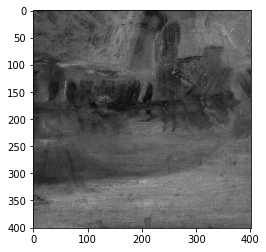

In [87]:
plt.imshow(target, cmap=plt.cm.gray)

In [74]:
input_shape = [1, 1, 15]
input_layer = keras.layers.Input(shape=input_shape)
num_layers = 2
filters = 15

layer = input_layer
for i in range(num_layers):
    layer = keras.layers.Conv2D(filters=25,
                                kernel_size=1,
                                activation='sigmoid',
                                padding='same')(layer)
output_layer = keras.layers.Dense(units=1, activation='sigmoid')(layer)
model = keras.Model(inputs=input_layer, outputs=output_layer)

In [75]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 1, 1, 15)]        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 1, 1, 25)          400       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 1, 1, 25)          650       
_________________________________________________________________
dense_13 (Dense)             (None, 1, 1, 1)           26        
Total params: 1,076
Trainable params: 1,076
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error']
              )

callbacks = [tf.keras.callbacks.EarlyStopping(patience=6,
                                              min_delta=10 ** -5)]
history = model.fit(ins,
                    outs,
                    epochs=10,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=callbacks
                    )

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 52us/sample - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0050 - val_mean_squared_error: 0.0050

In [77]:
print(model.predict(inputs).shape)
print(outputs.shape)
# calculate gain and print it out
gain = abs(outputs - model.predict(inputs)) / (outputs.shape[0] * outputs.shape[1])
print('Gain: {:1.4e}'.format(gain.flatten().max()))

(160801, 1, 1, 1)
(160801, 1, 1, 1)
Gain: 3.6240e-06


In [63]:
a = np.reshape(inputs, [160801, 1, 1, 15])
b = np.squeeze(outputs)
gain = abs(b - np.squeeze(model.predict(a))) / (b.shape[0])